# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

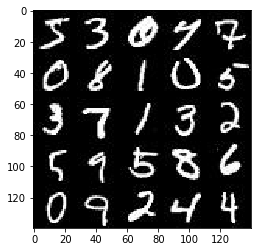

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

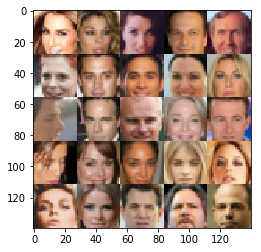

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer. You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\agoil\\Anaconda3\\envs\\dlnd\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\agoil\\Anaconda3\\envs\\dlnd\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\agoil\\Anaconda3\\envs\\dlnd\\lib\\site-packages\\ipykernel\\__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\agoil\\Anaconda3\\envs\\dlnd\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\agoil\\Anaconda3\\envs\\dlnd\\lib\\site-packages\\ipykernel\\kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "C:\\Users\\ag

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x512
        
        #x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        #bn4 = tf.layers.batch_normalization(x4, training=True)
        #relu4 = tf.maximum(alpha * bn4, bn4)
        # 2x2x512

        # Flatten it
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
            
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [24]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
import pickle as pkl

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    sample_z = np.random.uniform(-1, 1, size=[25, z_dim])
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # normalize
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[-1], data_image_mode)
                    gen_samples = sess.run(generator(input_z, data_shape[-1], False), feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)                
    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.2651... Generator Loss: 23.8697
Epoch 1/2... Discriminator Loss: 5.5050... Generator Loss: 0.0094
Epoch 1/2... Discriminator Loss: 2.5684... Generator Loss: 0.1846
Epoch 1/2... Discriminator Loss: 1.9886... Generator Loss: 12.8609
Epoch 1/2... Discriminator Loss: 0.7675... Generator Loss: 2.0489
Epoch 1/2... Discriminator Loss: 0.7201... Generator Loss: 2.2133
Epoch 1/2... Discriminator Loss: 0.7257... Generator Loss: 1.6754
Epoch 1/2... Discriminator Loss: 0.5251... Generator Loss: 4.2358
Epoch 1/2... Discriminator Loss: 0.5629... Generator Loss: 2.0964
Epoch 1/2... Discriminator Loss: 0.4752... Generator Loss: 3.2307


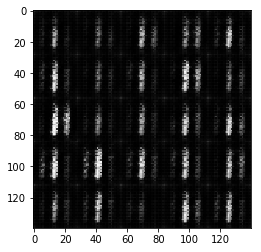

Epoch 1/2... Discriminator Loss: 0.6273... Generator Loss: 6.6574
Epoch 1/2... Discriminator Loss: 0.4120... Generator Loss: 3.3105
Epoch 1/2... Discriminator Loss: 0.5060... Generator Loss: 3.5981
Epoch 1/2... Discriminator Loss: 0.6074... Generator Loss: 7.9750
Epoch 1/2... Discriminator Loss: 0.6911... Generator Loss: 2.9391
Epoch 1/2... Discriminator Loss: 0.7405... Generator Loss: 1.4508
Epoch 1/2... Discriminator Loss: 0.4457... Generator Loss: 3.6056
Epoch 1/2... Discriminator Loss: 0.5981... Generator Loss: 1.8889
Epoch 1/2... Discriminator Loss: 0.5450... Generator Loss: 2.6424
Epoch 1/2... Discriminator Loss: 0.5789... Generator Loss: 2.0944


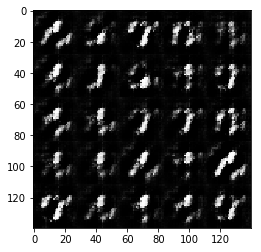

Epoch 1/2... Discriminator Loss: 0.6758... Generator Loss: 1.9973
Epoch 1/2... Discriminator Loss: 1.2025... Generator Loss: 6.4110
Epoch 1/2... Discriminator Loss: 0.9519... Generator Loss: 5.7342
Epoch 1/2... Discriminator Loss: 0.7819... Generator Loss: 1.3775
Epoch 1/2... Discriminator Loss: 0.9503... Generator Loss: 2.1593
Epoch 1/2... Discriminator Loss: 0.5790... Generator Loss: 2.5177
Epoch 1/2... Discriminator Loss: 0.6480... Generator Loss: 3.0687
Epoch 1/2... Discriminator Loss: 0.7438... Generator Loss: 2.3584
Epoch 1/2... Discriminator Loss: 0.9227... Generator Loss: 3.0191
Epoch 1/2... Discriminator Loss: 1.1109... Generator Loss: 0.8430


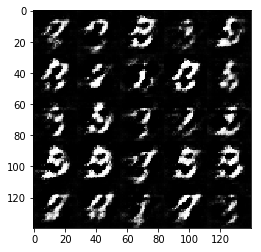

Epoch 1/2... Discriminator Loss: 1.0178... Generator Loss: 0.9773
Epoch 1/2... Discriminator Loss: 1.0507... Generator Loss: 1.1148
Epoch 1/2... Discriminator Loss: 0.9682... Generator Loss: 1.8106
Epoch 1/2... Discriminator Loss: 0.7128... Generator Loss: 1.8881
Epoch 1/2... Discriminator Loss: 0.6091... Generator Loss: 2.7961
Epoch 1/2... Discriminator Loss: 0.9438... Generator Loss: 3.9954
Epoch 1/2... Discriminator Loss: 0.8854... Generator Loss: 1.2367
Epoch 1/2... Discriminator Loss: 0.6907... Generator Loss: 1.6921
Epoch 1/2... Discriminator Loss: 1.2452... Generator Loss: 0.8339
Epoch 1/2... Discriminator Loss: 1.0464... Generator Loss: 0.9223


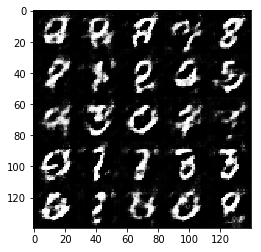

Epoch 1/2... Discriminator Loss: 1.1401... Generator Loss: 3.3263
Epoch 1/2... Discriminator Loss: 1.1468... Generator Loss: 0.9238
Epoch 1/2... Discriminator Loss: 0.7435... Generator Loss: 1.9487
Epoch 1/2... Discriminator Loss: 0.8651... Generator Loss: 1.9666
Epoch 1/2... Discriminator Loss: 0.8501... Generator Loss: 2.4222
Epoch 1/2... Discriminator Loss: 1.1375... Generator Loss: 3.7354
Epoch 2/2... Discriminator Loss: 0.8090... Generator Loss: 1.7134
Epoch 2/2... Discriminator Loss: 0.7712... Generator Loss: 2.0066
Epoch 2/2... Discriminator Loss: 0.8428... Generator Loss: 1.7124
Epoch 2/2... Discriminator Loss: 0.7395... Generator Loss: 1.9617


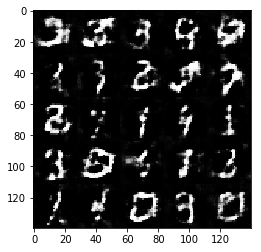

Epoch 2/2... Discriminator Loss: 0.7126... Generator Loss: 2.2599
Epoch 2/2... Discriminator Loss: 1.0827... Generator Loss: 0.8226
Epoch 2/2... Discriminator Loss: 0.8059... Generator Loss: 1.6524
Epoch 2/2... Discriminator Loss: 1.5983... Generator Loss: 0.4893
Epoch 2/2... Discriminator Loss: 1.0631... Generator Loss: 3.0253
Epoch 2/2... Discriminator Loss: 0.8267... Generator Loss: 2.4205
Epoch 2/2... Discriminator Loss: 0.8440... Generator Loss: 2.1559
Epoch 2/2... Discriminator Loss: 0.9078... Generator Loss: 2.2842
Epoch 2/2... Discriminator Loss: 0.8780... Generator Loss: 1.1615
Epoch 2/2... Discriminator Loss: 0.8864... Generator Loss: 1.1308


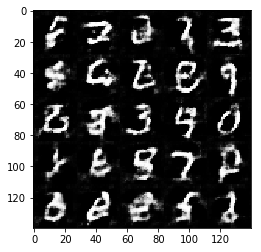

Epoch 2/2... Discriminator Loss: 0.8991... Generator Loss: 1.1447
Epoch 2/2... Discriminator Loss: 0.7980... Generator Loss: 1.8333
Epoch 2/2... Discriminator Loss: 0.9591... Generator Loss: 1.1357
Epoch 2/2... Discriminator Loss: 0.7890... Generator Loss: 1.3786
Epoch 2/2... Discriminator Loss: 0.9731... Generator Loss: 1.9472
Epoch 2/2... Discriminator Loss: 1.0343... Generator Loss: 2.1800
Epoch 2/2... Discriminator Loss: 0.9822... Generator Loss: 2.3383
Epoch 2/2... Discriminator Loss: 0.8691... Generator Loss: 1.3811
Epoch 2/2... Discriminator Loss: 0.9688... Generator Loss: 2.6175
Epoch 2/2... Discriminator Loss: 1.1608... Generator Loss: 0.7580


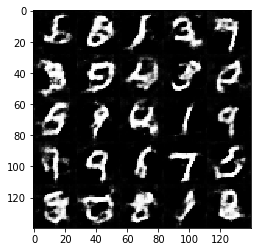

Epoch 2/2... Discriminator Loss: 0.8802... Generator Loss: 1.2996
Epoch 2/2... Discriminator Loss: 0.8258... Generator Loss: 2.2744
Epoch 2/2... Discriminator Loss: 0.8872... Generator Loss: 1.6400
Epoch 2/2... Discriminator Loss: 0.9466... Generator Loss: 2.1798
Epoch 2/2... Discriminator Loss: 1.2684... Generator Loss: 0.8176
Epoch 2/2... Discriminator Loss: 0.7831... Generator Loss: 1.8174
Epoch 2/2... Discriminator Loss: 1.1308... Generator Loss: 0.8271
Epoch 2/2... Discriminator Loss: 0.8864... Generator Loss: 1.1757
Epoch 2/2... Discriminator Loss: 1.0053... Generator Loss: 0.8912
Epoch 2/2... Discriminator Loss: 1.0323... Generator Loss: 2.4654


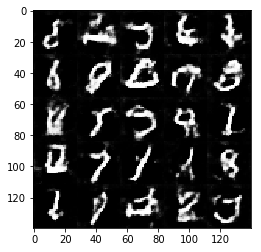

Epoch 2/2... Discriminator Loss: 0.8693... Generator Loss: 1.2873
Epoch 2/2... Discriminator Loss: 0.8878... Generator Loss: 2.1602
Epoch 2/2... Discriminator Loss: 0.8133... Generator Loss: 1.3087
Epoch 2/2... Discriminator Loss: 0.7736... Generator Loss: 1.8829
Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 2.2283
Epoch 2/2... Discriminator Loss: 0.8722... Generator Loss: 1.1772
Epoch 2/2... Discriminator Loss: 0.9304... Generator Loss: 1.3805
Epoch 2/2... Discriminator Loss: 0.8483... Generator Loss: 1.8180
Epoch 2/2... Discriminator Loss: 1.1806... Generator Loss: 3.0657
Epoch 2/2... Discriminator Loss: 1.0168... Generator Loss: 2.4937


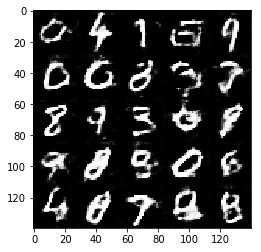

Epoch 2/2... Discriminator Loss: 1.4889... Generator Loss: 0.4765
Epoch 2/2... Discriminator Loss: 0.8775... Generator Loss: 2.2275
Epoch 2/2... Discriminator Loss: 0.7488... Generator Loss: 1.6615


In [31]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

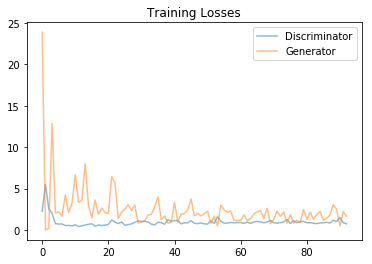

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 18.4940
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 0.7372... Generator Loss: 17.7168
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 4.2256
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 8.4027
Epoch 1/1... Discriminator Loss: 1.6432... Generator Loss: 0.5201
Epoch 1/1... Discriminator Loss: 0.9051... Generator Loss: 1.9613
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 2.2019
Epoch 1/1... Discriminator Loss: 1.9455... Generator Loss: 7.5392


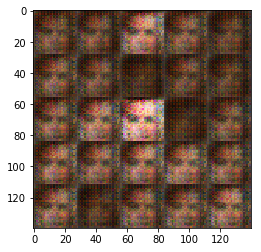

Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 5.1287
Epoch 1/1... Discriminator Loss: 2.4252... Generator Loss: 7.3739
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 1.9739
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 3.6273
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 1.6399
Epoch 1/1... Discriminator Loss: 1.8342... Generator Loss: 3.9709
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.2529
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.0495


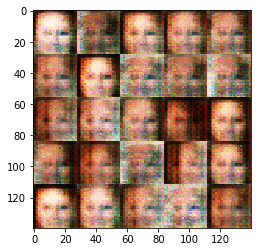

Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 1.8501
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 2.8122
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.6720
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.5352
Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 1.6580
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 2.0720
Epoch 1/1... Discriminator Loss: 0.9332... Generator Loss: 1.7238
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 2.7020
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.7617


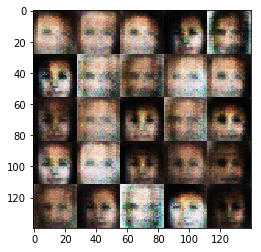

Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 1.2274
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 3.5480
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.3664
Epoch 1/1... Discriminator Loss: 2.2886... Generator Loss: 5.3569
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.9015
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 1.6503
Epoch 1/1... Discriminator Loss: 1.0598... Generator Loss: 0.8763


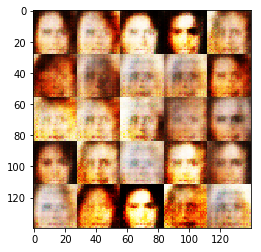

Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 1.9826
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 1.5466
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 2.2740
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 1.8930
Epoch 1/1... Discriminator Loss: 1.6782... Generator Loss: 3.4464
Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 1.3980
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.3515
Epoch 1/1... Discriminator Loss: 1.7477... Generator Loss: 4.1559
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.8379


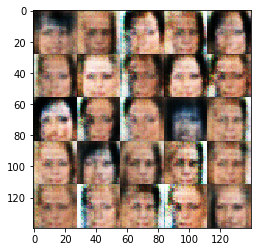

Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 1.5228
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 0.7954... Generator Loss: 1.3061
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 2.3325
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 2.9960
Epoch 1/1... Discriminator Loss: 0.7737... Generator Loss: 1.8978
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.2042
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 1.0650


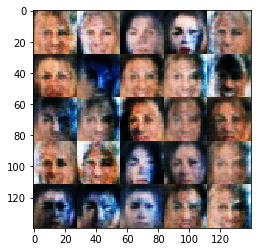

Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 1.4967
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 1.6275
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 1.9318
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 3.2742
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 2.9081
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.6068


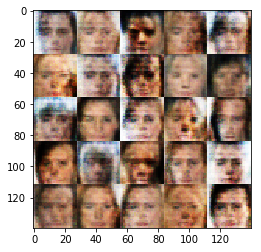

Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 1.0365
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.4691
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.1356
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 2.7922
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 0.8665


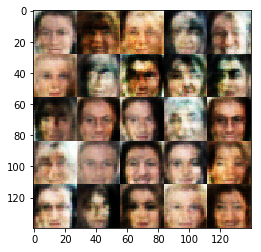

Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 3.1606
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 2.3791
Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 1.4388
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 1.4377
Epoch 1/1... Discriminator Loss: 1.6556... Generator Loss: 0.3665
Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 1.4607
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 1.2421
Epoch 1/1... Discriminator Loss: 1.7885... Generator Loss: 3.7677


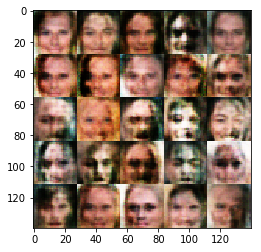

Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 2.4132
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 1.9615
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.6316
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 1.8127
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.9699


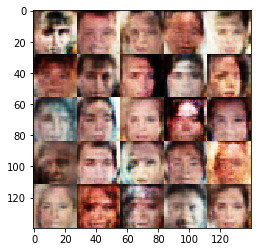

Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 2.1504
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 1.5944
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 1.1258
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.3657
Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 1.5937
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 1.8476


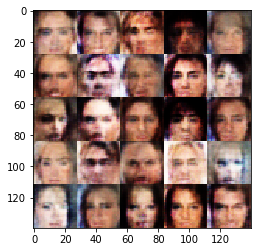

Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 1.3521
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 2.3065
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 2.3707
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 1.0598
Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 1.4345
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 2.1415
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 1.8945
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 1.2350


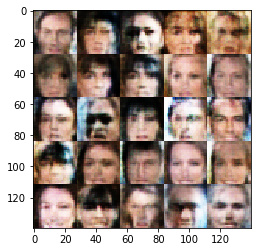

Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 1.4282
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.0313
Epoch 1/1... Discriminator Loss: 2.5166... Generator Loss: 4.3659
Epoch 1/1... Discriminator Loss: 0.9685... Generator Loss: 1.0398
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 1.1219
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.1835
Epoch 1/1... Discriminator Loss: 1.6677... Generator Loss: 0.3868
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 0.8803


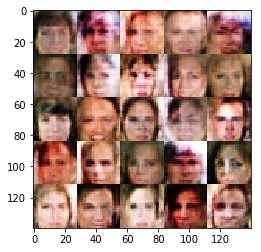

Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 1.5396
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 2.1321
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 1.1348
Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.6708
Epoch 1/1... Discriminator Loss: 1.6143... Generator Loss: 0.3786
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.6024
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.6045
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 1.4443
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 1.1909


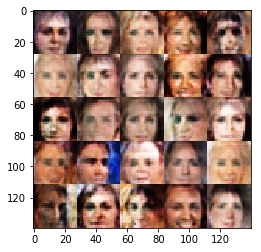

Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 2.3319
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 1.7935
Epoch 1/1... Discriminator Loss: 0.8462... Generator Loss: 1.6584
Epoch 1/1... Discriminator Loss: 1.4909... Generator Loss: 3.0283
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 1.6700
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.5750
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 2.2741
Epoch 1/1... Discriminator Loss: 0.8433... Generator Loss: 1.6365


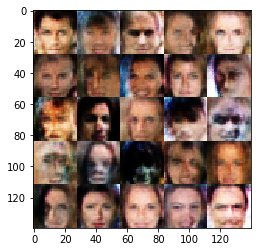

Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 2.0246
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 1.3179
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 2.0463
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 2.5643
Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 1.9944
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 2.4498


In [33]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

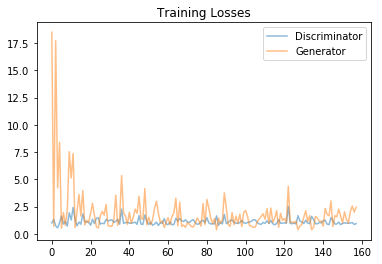

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.